In [1]:
import os
os.chdir("..")

from agents.utils import create_bins, discretize_observation
from scipy import stats
from ast import literal_eval
from collections import Counter

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import warnings
import numpy as np
import pandas as pd
import json
import ast

### Permutation test: Early vs Late MAPE (data: 20 run x 35 trials)

In [2]:
def run_glm(y, x):
    regressors = x
    regressors = sm.add_constant(regressors)
    model = sm.OLS(y, regressors).fit()

    # test multiple regression;
    alpha = model.params[0]
    beta = model.params[1]
    return alpha, beta

def mean_absolute_percentage_error(log_data):
    all_mape = []
    for i in range(len(log_data)):
        if i == 0:
            hrf = np.array(literal_eval(log_data[0]["hrf"]))
            reward = np.array(literal_eval(log_data[-1]["reward"]))
            n_trials = len(log_data)
        else:
            q_table = np.array(literal_eval(log_data[i]["q_table"])).reshape(10, 10)
            action = np.array(literal_eval(log_data[i]["current action"]))
            fmridata = np.array(literal_eval(log_data[i]["fmri_data"]))

            # clip action max values to avoid going out of bounds;
            if action[0] == 1.0:
                action[0] = 0.9

            if action[1] == 1.0:
                action[1] = 0.9

            q_val = q_table[int(action[0]*10), int(action[1]*10)]
            #alpha, beta = run_glm(hrf, fmridata)
            #reward = (beta / alpha) * 100

            all_mape.append( abs(( reward[i - 1] - q_val) / reward[i - 1] ) )

    return all_mape

data_path = "./data"
mape = []
steps = 35

for folder in os.listdir(data_path):
    folder_path = os.path.join(data_path, folder)

    # Check if it's a directory
    if os.path.isdir(folder_path):
        # Construct the paths for data_1/log and data_2/log
        data_1_log_path = os.path.join(folder_path, "data_1/log", "log.json")
        data_2_log_path = os.path.join(folder_path, "data_2/log", "log.json")

        # Read log.json from data_1
        if os.path.exists(data_1_log_path):
            with open(data_1_log_path, "r") as file_1:
                log_data_1 = json.load(file_1)
                score = mean_absolute_percentage_error(log_data_1)
                if len(mape) == 0:
                    mape = score[:steps]
                else:
                    mape = np.vstack((mape, score[:steps]))

        # Read log.json from data_2
        if os.path.exists(data_2_log_path):
            with open(data_2_log_path, "r") as file_2:
                log_data_2 = json.load(file_2)
                score = mean_absolute_percentage_error(log_data_2)
                if len(mape) == 0:
                    mape = score[:steps]
                else:
                    mape = np.vstack((mape, score[:steps]))

In [3]:
def permutation_test_mape_trend(mape_data, n_permutations=10000, num_edge_trials=5):
    """Minimal permutation test for MAPE trend, returns DataFrame and plot figure."""

    if not isinstance(mape_data, np.ndarray) or mape_data.ndim != 2:
        raise ValueError("mape_data must be a 2D NumPy array.")

    n_runs, n_trials = mape_data.shape

    if num_edge_trials <= 0 or num_edge_trials * 2 > n_trials:
        raise ValueError(f"num_edge_trials ({num_edge_trials}) invalid for n_trials ({n_trials}).")

    mean_early_observed = np.nanmean(mape_data[:, :num_edge_trials])
    mean_late_observed = np.nanmean(mape_data[:, -num_edge_trials:])
    observed_diff = mean_late_observed - mean_early_observed

    if np.isnan(observed_diff):
         raise ValueError("Observed difference is NaN. Check input data.")

    permutation_diffs = np.zeros(n_permutations)
    for i in range(n_permutations):
        shuffled_mape = np.array([np.random.permutation(run) for run in mape_data])
        mean_shuffled_early = np.nanmean(shuffled_mape[:, :num_edge_trials])
        mean_shuffled_late = np.nanmean(shuffled_mape[:, -num_edge_trials:])
        permutation_diffs[i] = mean_shuffled_late - mean_shuffled_early

    valid_perm_diffs = permutation_diffs[~np.isnan(permutation_diffs)]
    num_valid_perms = len(valid_perm_diffs)

    if num_valid_perms < n_permutations:
         warnings.warn(f"Removed {n_permutations - num_valid_perms} NaN results from permutations.", UserWarning)
         if num_valid_perms == 0:
              raise ValueError("All permutation statistics resulted in NaN.")

    p_value = np.mean(valid_perm_diffs <= observed_diff)

    fig, ax = plt.subplots(figsize=(8, 5))
    ax.hist(valid_perm_diffs, bins=50, alpha=0.7, label='Permutation Differences')
    ax.axvline(observed_diff, color='red', linestyle='dashed', linewidth=2,
               label=f'Observed Diff ({observed_diff:.3f})')
    ax.set_xlabel("Difference (Mean Late MAPE - Mean Early MAPE)")
    ax.set_ylabel("Frequency")
    ax.set_title(f"Permutation Test Distribution ({num_valid_perms} Permutations)")
    ax.legend()
    ax.grid(True, alpha=0.3)
    fig.tight_layout()

    results_data = {
        "Metric": ["Mean Early MAPE", "Mean Late MAPE", "Observed Difference (Late - Early)", "P-value (one-sided)", "Num Valid Permutations"],
        "Value": [mean_early_observed, mean_late_observed, observed_diff, p_value, num_valid_perms]
    }
    results_df = pd.DataFrame(results_data)
    results_df['Value'] = results_df['Value'].apply(lambda x: f"{x:.4f}" if isinstance(x, float) else x)

    return results_df, fig


--- Testing with Empirical MAPE Data ---

Permutation Test Results:
                            Metric      Value
                   Mean Early MAPE     0.3989
                    Mean Late MAPE     0.1685
Observed Difference (Late - Early)    -0.2304
               P-value (one-sided)     0.0000
            Num Valid Permutations 10000.0000

Displaying permutation distribution plot...


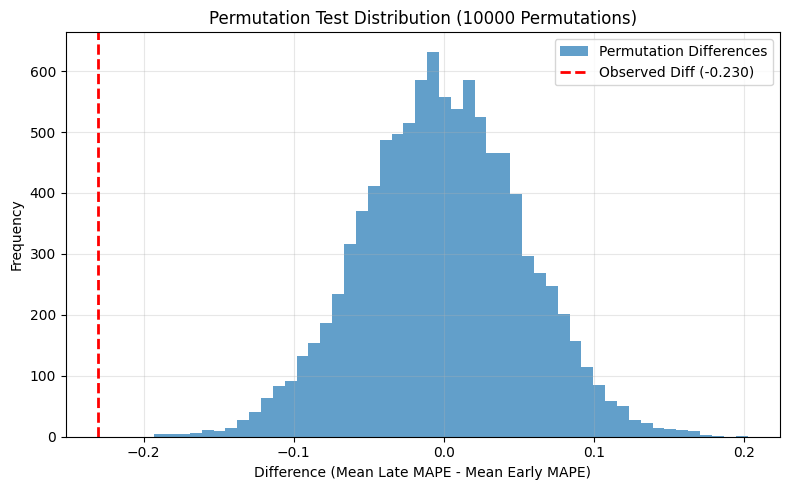

In [4]:
if mape is not None:
    print("\n--- Testing with Empirical MAPE Data ---")
    try:
        # Call the function with your actual 'mape' variable
        results_df_empirical, fig_empirical = permutation_test_mape_trend(
            mape, 
            n_permutations=10000, # Use a suitable number of permutations
            num_edge_trials=5      # Use 5 trials at each edge
        )
        
        print("\nPermutation Test Results:")
        print(results_df_empirical.to_string(index=False)) # Print DataFrame summary

        # Display the plot generated by the function
        print("\nDisplaying permutation distribution plot...")
        plt.show() 

    except ValueError as e:
        print(f"\nError during permutation test: {e}")
    except Exception as e:
        print(f"\nAn unexpected error occurred during the test: {e}")
else:
    print("\nSkipping permutation test because 'mape' data was not loaded/defined correctly.")

### MAPE statistics (all subjects and runs)

In [3]:
import numpy as np
import pandas as pd
from scipy.stats import linregress
import json
import os
from ast import literal_eval

def calculate_slope_and_p_value(timeseries, n_permutations=1000):
    trials = np.arange(len(timeseries))
    if len(timeseries) < 2:
        return np.nan, np.nan
    valid_indices = ~np.isnan(timeseries)
    num_valid = np.sum(valid_indices)
    if num_valid < 2:
         return np.nan, np.nan
    trials_valid = trials[valid_indices]
    timeseries_valid = timeseries[valid_indices]
    # Check for constant values among valid points;
    if np.all(np.isclose(timeseries_valid, timeseries_valid[0])):
         # Return slope 0 and p-value 1 if all valid points are constant;
         return 0.0, 1.0

    observed_slope, _, _, _, _ = linregress(trials_valid, timeseries_valid)
    permuted_slopes = np.zeros(n_permutations)
    for i in range(n_permutations):
        # Permute only the valid timeseries data;
        permuted_valid_values = np.random.permutation(timeseries_valid)
        # Recalculate slope on permuted valid data;
        slope, _, _, _, _ = linregress(trials_valid, permuted_valid_values)
        permuted_slopes[i] = slope

    p_value = (np.sum(permuted_slopes <= observed_slope) + 1) / (n_permutations + 1)
    return observed_slope, p_value

def safe_literal_eval(val):
    if not isinstance(val, str):
        return val
    try:
        return literal_eval(val)
    except (ValueError, SyntaxError, TypeError):
        return None

def read_parse_log(filepath):
    try:
        with open(filepath, 'r') as f:
            log_data = json.load(f)
        if not isinstance(log_data, list):
             return None
        return log_data
    except Exception:
        return None

def analyze_mape_improvement(mape_data, n_subjects, n_runs_per_subject, data_base_path="./data", n_permutations=1000, num_trials=35):
    expected_rows = n_subjects * n_runs_per_subject
    results = []
    trial_index_35 = num_trials - 1

    for i in range(expected_rows):
        subject_id_num = (i // n_runs_per_subject) + 1
        run_id_num = (i % n_runs_per_subject) + 1
        subject_id = f"sub-{subject_id_num:03d}"
        run_folder = f"data_{run_id_num}"
        log_file_path = os.path.join(data_base_path, subject_id, run_folder, "log", "log.json")

        snr_value = np.nan
        final_position = None
        log_data = read_parse_log(log_file_path)

        if log_data and len(log_data) >= num_trials:
            try:
                # --- Final Position Calculation (remains the same) ---
                log_35 = log_data[trial_index_35]
                contrast_35 = log_35.get("contrast")
                frequency_35 = log_35.get("frequency")
                if contrast_35 is not None and frequency_35 is not None:
                    final_position = [contrast_35, frequency_35]
                else:
                    final_position = [np.nan, np.nan]

                # --- New SNR Calculation (Mean Reward / Std Dev Reward) ---
                if len(log_data) > 0:
                    reward_overall_str = log_data[-1].get("reward")
                    reward_overall = safe_literal_eval(reward_overall_str)
                else:
                    reward_overall = None

                if reward_overall is not None and isinstance(reward_overall, list):
                    try:
                        reward_overall_np = np.array(reward_overall, dtype=float)
                        # Remove NaNs if any before calculation
                        reward_overall_np = reward_overall_np[~np.isnan(reward_overall_np)]

                        if reward_overall_np.size > 1: # Need more than 1 point for std dev
                            mean_reward = np.mean(reward_overall_np)
                            std_reward = np.std(reward_overall_np, ddof=1) # Sample std dev

                            if not np.isclose(std_reward, 0) and std_reward > 0: # Check std dev is positive and non-zero
                                snr_value = mean_reward / std_reward
                            elif np.isclose(std_reward, 0) and not np.isclose(mean_reward, 0):
                                snr_value = np.inf # Or np.nan, depending on desired handling
                            # else: snr_value remains np.nan if mean is also 0, or std_dev is negative/nan

                        # else: snr_value remains np.nan if not enough data points

                    except (ValueError, TypeError):
                         # Handle cases where conversion to float array fails
                         snr_value = np.nan # Keep snr_value as nan

            except Exception:
                # Broad catch to ensure loop continues if unexpected error occurs
                # Final position might remain None/nan, SNR remains nan
                pass

        # --- MAPE Slope Calculation (remains the same) ---
        run_mape_timeseries = mape_data[i, :]
        slope, p_value = calculate_slope_and_p_value(run_mape_timeseries, n_permutations=n_permutations)

        results.append({
            "Subject": subject_id,
            "Run": run_id_num,
            "MAPE Slope (Improvement)": slope,
            "P-value": p_value,
            "SNR": snr_value, # Updated SNR value
            "Final Position": final_position
        })

    results_df = pd.DataFrame(results)
    results_df = results_df[["Subject", "Run", "MAPE Slope (Improvement)", "P-value", "SNR", "Final Position"]]
    return results_df

In [4]:
N_SUBJECTS = 10
N_RUNS_PER_SUBJECT = 2
N_TRIALS = 35
DATA_BASE_PATH = "./data" # Adjust if your data is elsewhere

analysis_results_df = analyze_mape_improvement(
             mape,
             N_SUBJECTS,
             N_RUNS_PER_SUBJECT,
             data_base_path=DATA_BASE_PATH,
             num_trials=N_TRIALS
         )
analysis_results_df

,Subject,Run,MAPE Slope (Improvement),P-value,SNR,Final Position
0,sub-001,1,-0.016466,0.006993,3.757359,"[0.4, 0.5]"
1,sub-001,2,-0.008990,0.005994,3.393772,"[0.7, 0.2]"
2,sub-002,1,-0.001501,0.334665,2.853260,"[0.8, 0.8]"
3,sub-002,2,-0.001311,0.313686,3.486101,"[0.8, 0.1]"
4,sub-003,1,-0.013760,0.002997,2.919494,"[0.5, 0.1]"
5,sub-003,2,-0.007156,0.003996,4.630503,"[0.9, 0.9]"
6,sub-004,1,-0.008649,0.000999,6.849751,"[0.7, 0.4]"
7,sub-004,2,-0.009533,0.000999,4.947232,"[0.9, 0.9]"
8,sub-005,1,-0.015686,0.026973,3.180632,"[0.9, 0.8]"
9,sub-005,2,-0.004979,0.014985,4.152174,"[0.8, 0.9]"


### Mean MAPE improvement across timeseries

In [4]:
# Assuming chance level MAPE is 50%;
chance_level = 0.5

# Calculate improvement relative to chance level for each point
improvement = chance_level - mape

# Calculate the mean improvement for each timeseries
mean_improvement_per_timeseries = np.mean(improvement, axis=1)

# Calculate the overall mean improvement across all timeseries
mean_improvement_overall = np.mean(mean_improvement_per_timeseries)

# Calculate the standard deviation of the mean improvements across timeseries
std_dev_improvement = np.std(mean_improvement_per_timeseries)

print(f"Mean Improvement Across All Timeseries (from chance level {chance_level}): {mean_improvement_overall:.4f}")
print(f"Standard Deviation of Improvement Across Timeseries: {std_dev_improvement:.4f}")

Mean Improvement Across All Timeseries (from chance level 0.5): 0.2156
Standard Deviation of Improvement Across Timeseries: 0.0633


In [12]:
it_improvement = abs(analysis_results_df["MAPE Slope (Improvement)"].mean() * 100)
print(f"mean intertrial improvement: {it_improvement:.4f}")

mean intertrial improvement: 0.6533
